In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from scipy.constants import physical_constants
from sklearn.metrics import r2_score
import seaborn
seaborn.set()

def linear(x, a, b):
    return a*x + b

# Importando os dados

In [2]:
dados = pd.read_excel('campo-elétrico.xlsx')
dados

,E,ddp,z,v,tipo
0,1.659,10.1,0.1,ddp,disco
1,3.010,20.1,0.1,ddp,disco
2,4.600,30.0,0.1,ddp,disco
3,6.170,40.0,0.1,ddp,disco
4,7.710,50.1,0.1,ddp,disco
...,...,...,...,...,...
168,4.440,500.0,12.0,z,esfera
169,4.230,500.0,12.5,z,esfera
170,4.060,500.0,13.0,z,esfera
171,3.900,500.0,13.5,z,esfera


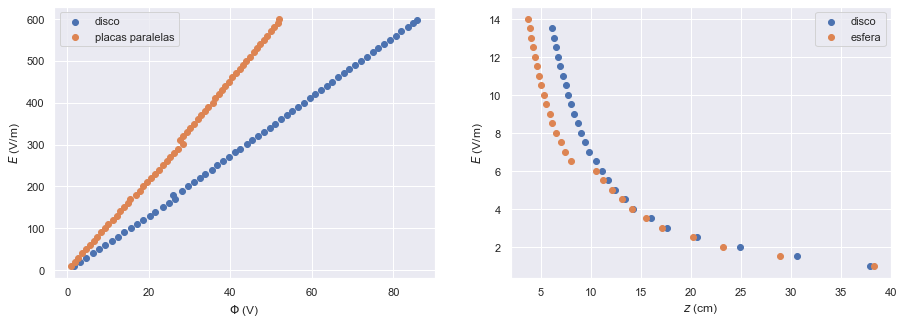

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
axis = {'ddp':ax1, 'z':ax2}

for (tipo, v), group in dados.groupby(['tipo', 'v']):
    axis[v].scatter(group.E, group[v], label=tipo)
    
ax1.set_xlabel(r'$\Phi$ (V)')
ax1.set_ylabel(r'$E$ (V/m)')
ax1.legend()

ax2.set_xlabel(r'$z$ (cm)')
ax2.set_ylabel(r'$E$ (V/m)')
ax2.legend()

plt.show()

# Análise da intensidade do campo em função da diferença de potencial ($E \times \Phi$)

In [4]:
ddp_dados = dados.loc[dados.v == 'ddp'].groupby('tipo')

## Verificação da mudança de escala do sensor

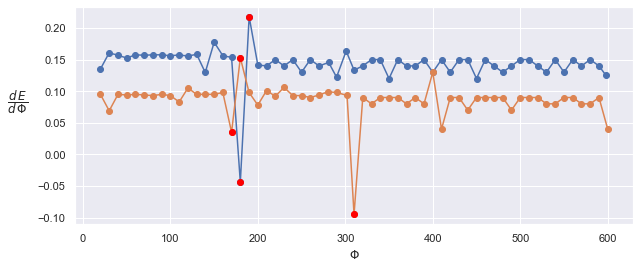

In [5]:
plt.figure(figsize=(10, 4))

split_slices = {}
for tipo, group in ddp_dados:
    dydx = group.E.diff()/group.ddp.diff()
    loc = (dydx - dydx.mean()).abs() > 0.05
    
    t = np.arange(len(group))
    split_slices[tipo] = [0] + list(t[loc]) + [t[-1]]
    
    x = group.ddp
    plt.plot(x, dydx, 'o-')
    plt.plot(x.loc[loc], dydx.loc[loc], 'o', c='red')
    
plt.ylabel(r'$\dfrac{d\,E}{d\,\Phi}$', rotation=0, labelpad=20)
plt.xlabel(r'$\Phi$')
plt.show()

In [6]:
split_slices

{'disco': [0, 17, 18, 59], 'placas paralelas': [0, 16, 17, 30, 59]}

## Ajustes de curva

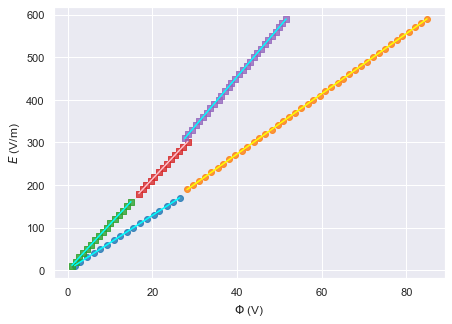

In [14]:
plt.figure(figsize=(7, 5))

color = iter(zip(mcolors.TABLEAU_COLORS.keys(), 
                 ('cyan', 'yellow', 'cyan', 'pink', 'cyan')))

resultados = {'disco':[], 'placas paralelas':[]}
for (tipo, group) in ddp_dados:
    for i, j in zip(split_slices[tipo][:-1], split_slices[tipo][1:]):
        if j - i > 1:
            x, y = group[['E', 'ddp']].values[i:j].T
            sc, pc = next(color)
            plt.scatter(x, y, c=sc, marker='o' if tipo == 'disco' else 's', alpha=0.8)
            
            (a, b), pcov = curve_fit(linear, x, y)
            resultados[tipo].append([a, b] + list(np.sqrt(np.diag(pcov))))
            
            X = np.linspace(x.min(), x.max(), 15)
            plt.plot(X, linear(X, a, b), c=pc)
    
plt.xlabel(r'$\Phi$ (V)')
plt.ylabel(r'$E$ (V/m)')
#plt.legend()

plt.show()

In [19]:
resultados = {k:pd.DataFrame(v, columns=('a', 'b', 'std_a', 'std_b')) for k, v in resultados.items()}

In [20]:
resultados

{'disco':           a         b     std_a     std_b
 0  6.420600  0.304656  0.014325  0.228112
 1  7.067571 -9.887133  0.005247  0.309618,
 'placas paralelas':            a          b     std_a     std_b
 0  10.724910   0.782554  0.050575  0.453054
 1  10.544909   3.088058  0.041940  0.954710
 2  11.693635 -13.713124  0.028943  1.166267}